Library imports

In [1]:
import pandas as pd
import rasterio
import seaborn as sns
from shapely import wkt

import utilities as utils

Loads the datacube

In [2]:
data_aus = utils.load_dataset('data/datacube_sri_aus.csv')
data_uscan = utils.load_dataset('data/datacube_sri_uscan.csv')

In [3]:
data_aus.rename({
    'GeophysicsLAB_Australia_resampled' : 'GeophysicsLAB',
    'GeophysicsMoho_Australia_resampled' : 'GeophysicsMoho',
    'GeophysicsSatelliteGravity_ShapeIndex_Australia_resampled' : 'GeophysicsSatelliteGravity_ShapeIndex',
    'GeophysicsGravity_Australia' : 'GeophysicsGravity', 
    'GeophysicsGravity_HGM_Australia' : 'GeophysicsGravity_HGM',
    'GeophysicsGravity_UpCont30km_Australia' : 'GeophysicsGravity_UpCont30km',
    'GeophysicsGravity_UpCont30km_HGM_Australia' : 'GeophysicsGravity_UpCont30km_HGM',
    'GeophysicsMagRTP_Australia' : 'GeophysicsMagRTP', 
    'GeophysicsMagRTP_DeepSources_Australia' : 'GeophysicsMagRTP_DeepSources',
    'GeophysicsMagRTP_VD_Australia' : 'GeophysicsMagRTP_VD',
    'GeophysicsMagRTP_HGM_Australia_resampled' : 'GeophysicsMagRTP_HGM',
    'GeophysicsMagRTP_HGMDeepSources_Australia_resampled' : 'GeophysicsMagRTP_HGMDeepSources',
    'ShallowGravitySources_Worms_Australia' : 'ShallowGravitySources_Worms',
    'DeepGravitySources_Worms_Australia' : 'DeepGravitySources_Worms',
    'ShallowMagSources_Worms_Australia' : 'ShallowMagSources_Worms', 
    'DeepMagSources_Worms_Australia' : 'DeepMagSources_Worms'
}, axis=1, inplace=True)
data_aus["Continent_Majority"] = "Oceania"

data_uscan.rename({
    'GeophysicsLAB_USCanada_resampled' : 'GeophysicsLAB', 
    'USCanada_Moho_resampled' : 'GeophysicsMoho',
    'GeophysicsSatelliteGravity_ShapeIndex_USCanada_resampled' : 'GeophysicsSatelliteGravity_ShapeIndex',
    'GeophysicsGravity_USCanada_resampled' : 'GeophysicsGravity',
    'GeophysicsGravity_HGM_USCanada_resampled' : 'GeophysicsGravity_HGM',
    'GeophysicsGravity_Up30km_USCanada_resampled' : 'GeophysicsGravity_UpCont30km',
    'GeophysicsGravity_Up30km_HGM_USCanada_resampled' : 'GeophysicsGravity_UpCont30km_HGM',
    'GeophysicsMag_RTP_USCanada_resampled' : 'GeophysicsMagRTP', 
    'USCanadaMagRTP_DeepSources_resampled' : 'GeophysicsMagRTP_DeepSources',
    'GeophysicsMag_RTP_VD_USCanada_resampled' : 'GeophysicsMagRTP_VD',
    'GeophysicsMag_RTP_HGM_USCanada_resampled' : 'GeophysicsMagRTP_HGM',
    'USCanadaMagRTP_HGMDeepSources_resampled' : 'GeophysicsMagRTP_HGMDeepSources',
    'ShallowGravitySources_Worms_USCanada' : 'ShallowGravitySources_Worms',
    'DeepGravitySources_Worms_USCanada' : 'DeepGravitySources_Worms', 
    'ShallowMagSources_Worms_USCanada' : 'ShallowMagSources_Worms',
    'DeepMagSources_Worms_USCanada' : 'DeepMagSources_Worms'
}, axis=1, inplace=True)
data_uscan["Continent_Majority"] = "North America"

Concatenates continent datacubes

In [4]:
# data = pd.concat((data_aus, data_uscanada), ignore_index = True)
# data.reset_index(drop=True, inplace=True)
data_aus['Lat'] = data_aus['s2_cell_center'].apply(lambda x: float(x.rsplit(',',1)[1][:-1]))
data_aus['Lng'] = data_aus['s2_cell_center'].apply(lambda x: float(x.rsplit(',',1)[0][1:]))

data_uscan['Lat'] = data_uscan['s2_cell_center'].apply(lambda x: float(x.rsplit(',',1)[1][:-1]))
data_uscan['Lng'] = data_uscan['s2_cell_center'].apply(lambda x: float(x.rsplit(',',1)[0][1:]))
# data.dtypes

Selects the data /labels used for MVT WOE baseline

In [5]:
cols_dict = {
    's2_cell_poly' : None,                                      # Polygon with coordinates of the vertices
    'Continent_Majority' : None, 
    'GeophysicsLAB' : None,                                     # Depth to LAB
    'GeophysicsMoho' : None,                                    # Depth to Moho
    'GeophysicsSatelliteGravity_ShapeIndex' : None,             # Sattelite Gravity
    'GeophysicsGravity' : None,                                 # Gravity Bouger
    'GeophysicsGravity_HGM' : None,                             # Gravity HGM
    'GeophysicsGravity_UpCont30km_HGM' : None,                  # Gravity upward cont'd HGM
    'ShallowGravitySources_Worms' : None,                       # Gravity worms
    'DeepGravitySources_Worms' : None,                          # Gravity upward cont'd worms
    'GeophysicsMagRTP_HGM' : None,                              # Magnetic HGM
    'GeophysicsMagRTP_HGMDeepSources' : None,                   # Magnetic long-wavelength HGM
    'ShallowMagSources_Worms' : None,                           # Magnetic worms
    'DeepMagSources_Worms' : None,                              # Magnetic long-wavelength worms
    'MVT_Deposit' : None,
    'MVT_Occurrence' : None,
    'MVT_DepositOccurrence' : None,
    'MVT_DepositOccurrenceNeighbors' : None,
}

data_filtered_aus, cols = utils.extract_cols(data_aus, cols_dict)
data_filtered_uscan, cols = utils.extract_cols(data_uscan, cols_dict)

The following function finds all the neighbors and creates a new column "MVT_Deposit".
Original paper treats neighbors of polygons with "Training_MVT_Deposit=Present" and "Training_MVT_Occurrence=Present" as mineral present, "MVT_Deposit=Present" (note: now Deposit means - Deposit, Occurrence, or their neighbor). 

In [6]:
labels_filtered_aus = data_filtered_aus['MVT_DepositOccurrenceNeighbors']
geometry_filtered_aus = data_filtered_aus["s2_cell_poly"]
continent_filtered_aus = data_filtered_aus["Continent_Majority"]

labels_filtered_uscan = data_filtered_uscan['MVT_DepositOccurrenceNeighbors']
geometry_filtered_uscan = data_filtered_uscan["s2_cell_poly"]
continent_filtered_uscan = data_filtered_uscan["Continent_Majority"]

data_filtered_aus = data_filtered_aus.drop(columns=['s2_cell_poly', 'Continent_Majority', 'MVT_Deposit', 'MVT_Occurrence', 'MVT_DepositOccurrence', 'MVT_DepositOccurrenceNeighbors'])
data_filtered_uscan = data_filtered_uscan.drop(columns=['s2_cell_poly', 'Continent_Majority', 'MVT_Deposit', 'MVT_Occurrence', 'MVT_DepositOccurrence', 'MVT_DepositOccurrenceNeighbors'])

cols = cols[1:-4]

Clearly the dataset has MANY outliers, as reported in the paper

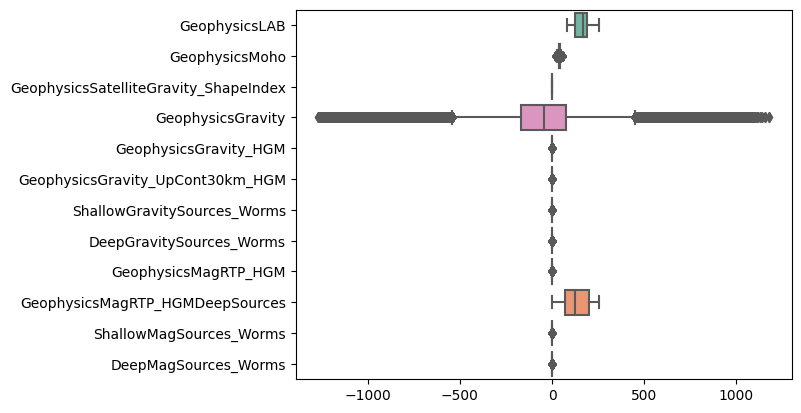

In [7]:
ax1 = sns.boxplot(data=data_filtered_aus, orient="h", palette="Set2")

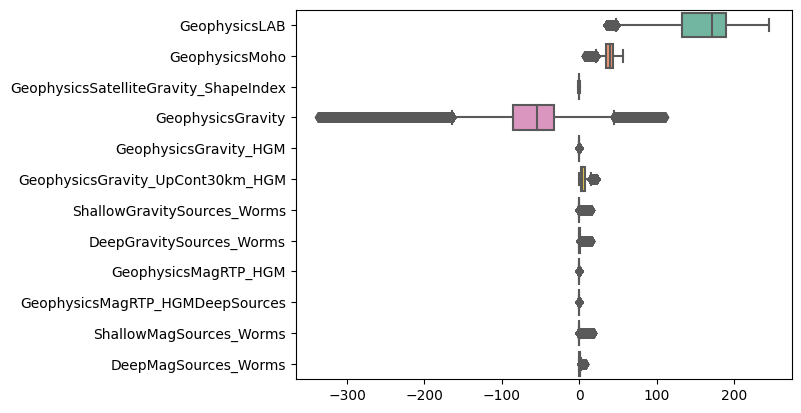

In [8]:
ax2 = sns.boxplot(data=data_filtered_uscan, orient="h", palette="Set2")

We can remove these outliers

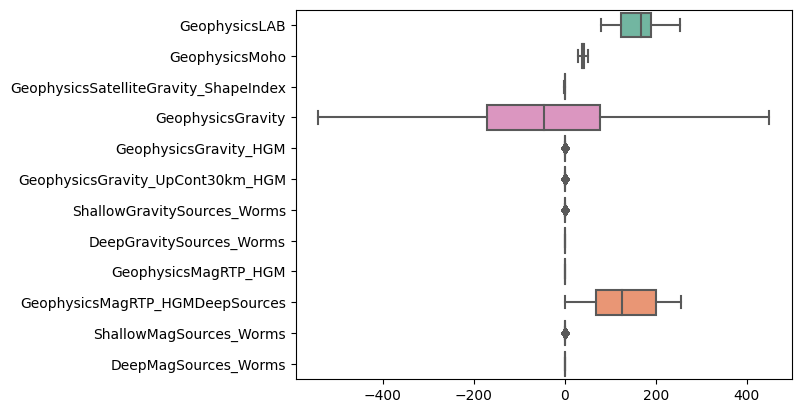

In [9]:
data_filtered_aus = utils.tukey_remove_outliers(data_filtered_aus)
ax1 = sns.boxplot(data=data_filtered_aus, orient="h", palette="Set2")

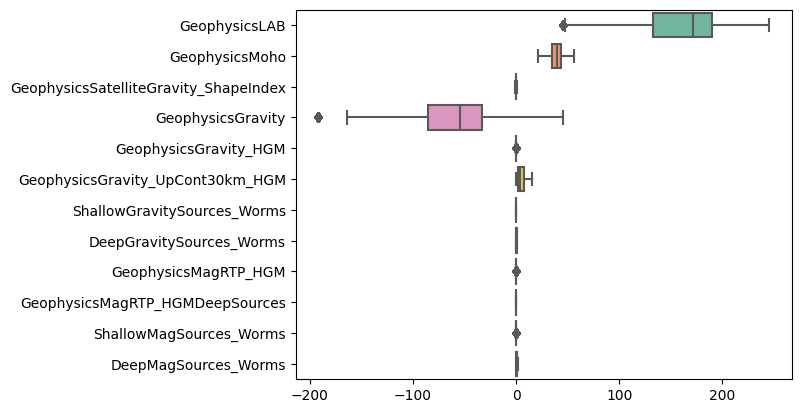

In [10]:
data_filtered_uscan = utils.tukey_remove_outliers(data_filtered_uscan)
ax2 = sns.boxplot(data=data_filtered_uscan, orient="h", palette="Set2")

There are also many NaNs in the data, these can be "imputed" with the mean value.

In [11]:
data_filtered_aus = utils.impute_nans(data_filtered_aus)
print(data_filtered_aus.isna().sum())
data_filtered_uscan = utils.impute_nans(data_filtered_uscan)
print(data_filtered_uscan.isna().sum())

GeophysicsLAB                            0
GeophysicsMoho                           0
GeophysicsSatelliteGravity_ShapeIndex    0
GeophysicsGravity                        0
GeophysicsGravity_HGM                    0
GeophysicsGravity_UpCont30km_HGM         0
ShallowGravitySources_Worms              0
DeepGravitySources_Worms                 0
GeophysicsMagRTP_HGM                     0
GeophysicsMagRTP_HGMDeepSources          0
ShallowMagSources_Worms                  0
DeepMagSources_Worms                     0
dtype: int64
GeophysicsLAB                            0
GeophysicsMoho                           0
GeophysicsSatelliteGravity_ShapeIndex    0
GeophysicsGravity                        0
GeophysicsGravity_HGM                    0
GeophysicsGravity_UpCont30km_HGM         0
ShallowGravitySources_Worms              0
DeepGravitySources_Worms                 0
GeophysicsMagRTP_HGM                     0
GeophysicsMagRTP_HGMDeepSources          0
ShallowMagSources_Worms                  

Finally, it can be observed the above data is not "normalized", we should make features standard scores / z-scores

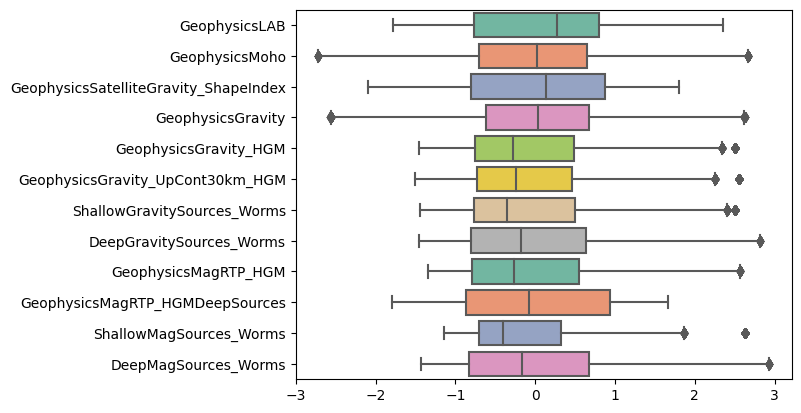

In [12]:
data_filtered_aus = utils.normalize_df(data_filtered_aus)
ax1 = sns.boxplot(data=data_filtered_aus, orient="h", palette="Set2")

(note remaining outliers above were within the Tukey fences calculated over ALL the data)


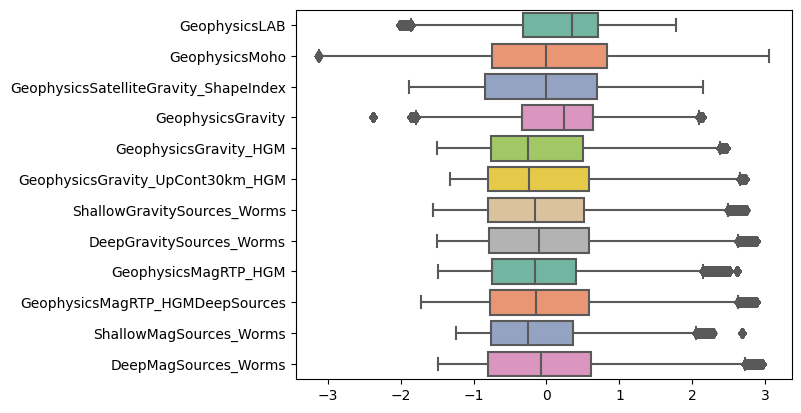

In [13]:
data_filtered_uscan = utils.normalize_df(data_filtered_uscan)
ax2 = sns.boxplot(data=data_filtered_uscan, orient="h", palette="Set2")
print("(note remaining outliers above were within the Tukey fences calculated over ALL the data)")

Adds back the labels, geometry, and continent

In [14]:
data_filtered_aus["target"] = labels_filtered_aus
data_filtered_aus["H3_Geometry"] = geometry_filtered_aus
data_filtered_aus["Continent_Majority"] = continent_filtered_aus

data_filtered_uscan["target"] = labels_filtered_uscan
data_filtered_uscan["H3_Geometry"] = geometry_filtered_uscan
data_filtered_uscan["Continent_Majority"] = continent_filtered_uscan

Finally, we can concatenate all data in one table

In [15]:
data_filtered = pd.concat((data_filtered_aus, data_filtered_uscan), ignore_index = True)
data_filtered.reset_index(drop=True, inplace=True)
data_filtered.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5660532 entries, 0 to 5660531
Data columns (total 15 columns):
 #   Column                                 Dtype  
---  ------                                 -----  
 0   GeophysicsLAB                          float64
 1   GeophysicsMoho                         float64
 2   GeophysicsSatelliteGravity_ShapeIndex  float64
 3   GeophysicsGravity                      float64
 4   GeophysicsGravity_HGM                  float64
 5   GeophysicsGravity_UpCont30km_HGM       float64
 6   ShallowGravitySources_Worms            float64
 7   DeepGravitySources_Worms               float64
 8   GeophysicsMagRTP_HGM                   float64
 9   GeophysicsMagRTP_HGMDeepSources        float64
 10  ShallowMagSources_Worms                float64
 11  DeepMagSources_Worms                   float64
 12  target                                 bool   
 13  H3_Geometry                            object 
 14  Continent_Majority                     object 
dty

Generates tiff files for every column, separate for US/Canada and Australia

/tmp/ipykernel_25320/2854990052.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  continent_datacube.rename({


Rasterizing Oceania


  0%|          | 0/13 [00:00<?, ?it/s]

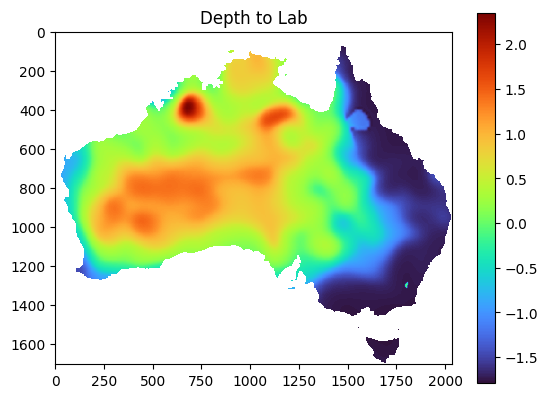

  8%|▊         | 1/13 [01:15<15:10, 75.91s/it]

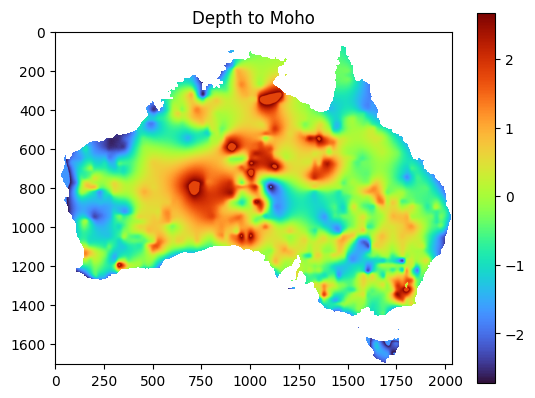

 15%|█▌        | 2/13 [02:31<13:54, 75.83s/it]

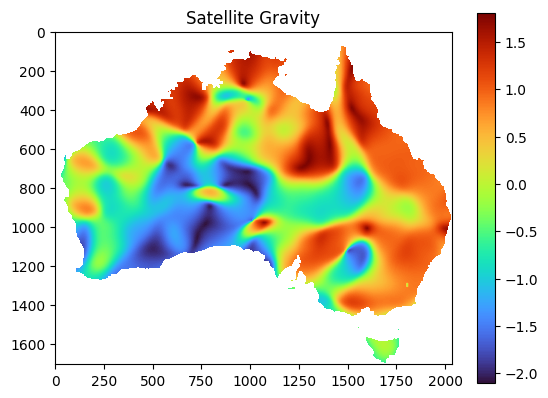

 23%|██▎       | 3/13 [03:46<12:35, 75.55s/it]

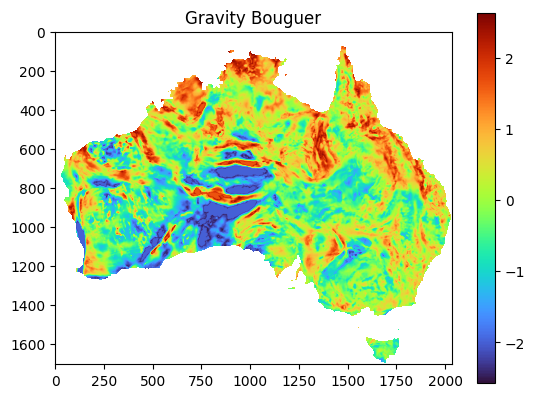

 31%|███       | 4/13 [05:05<11:29, 76.62s/it]

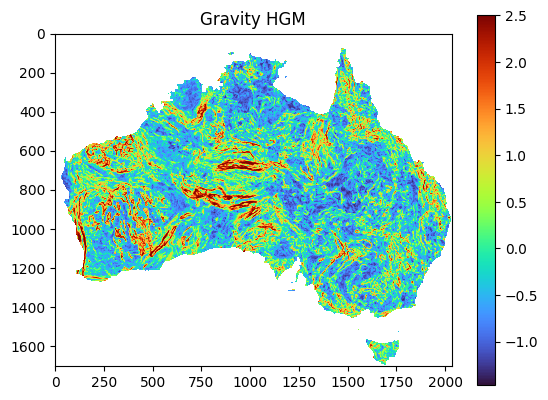

 38%|███▊      | 5/13 [06:19<10:07, 75.97s/it]

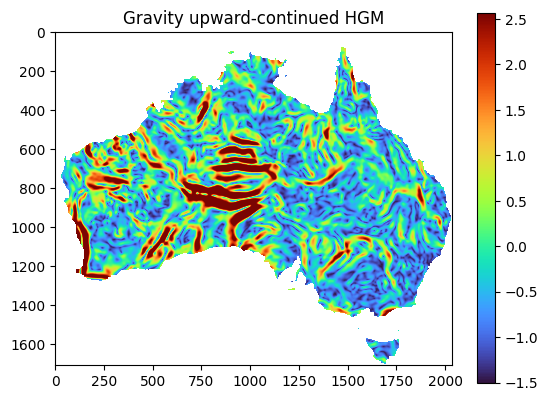

 46%|████▌     | 6/13 [07:36<08:52, 76.01s/it]

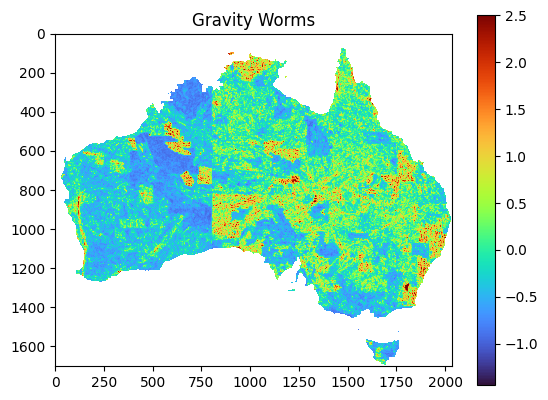

 54%|█████▍    | 7/13 [08:52<07:36, 76.09s/it]

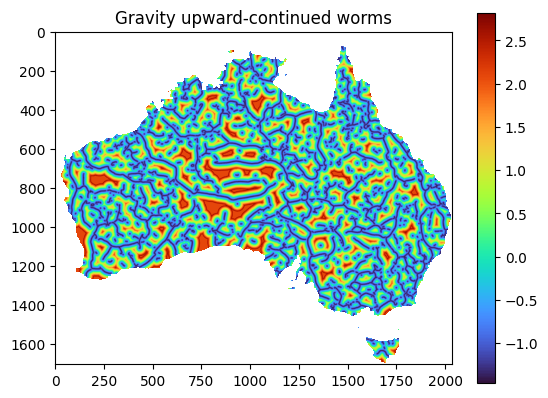

 62%|██████▏   | 8/13 [10:08<06:20, 76.14s/it]

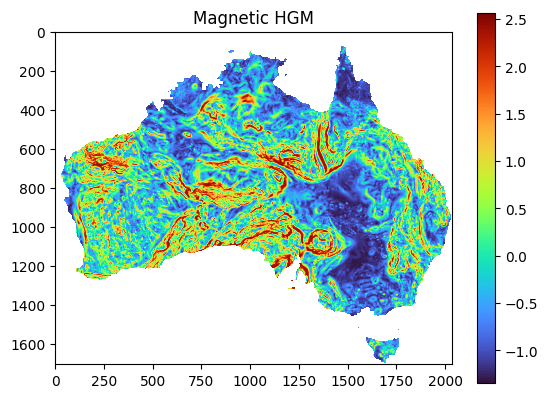

 69%|██████▉   | 9/13 [11:23<05:03, 75.83s/it]

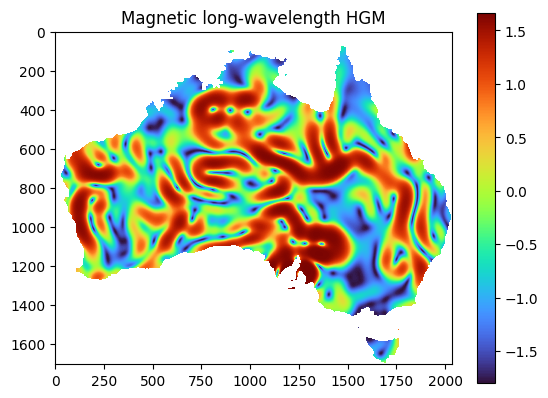

 77%|███████▋  | 10/13 [12:39<03:47, 75.81s/it]

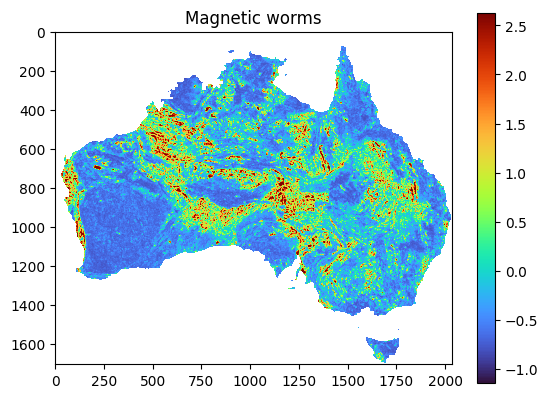

 85%|████████▍ | 11/13 [13:55<02:31, 75.95s/it]

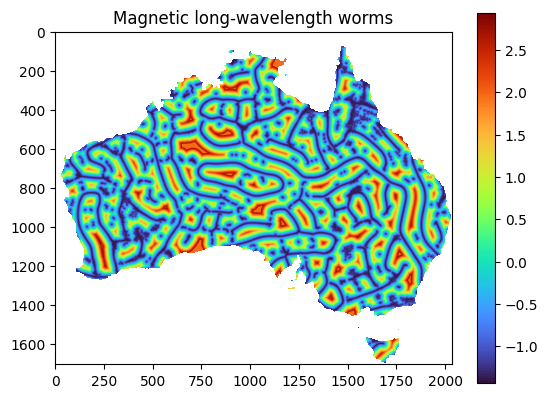

 92%|█████████▏| 12/13 [15:11<01:15, 75.94s/it]

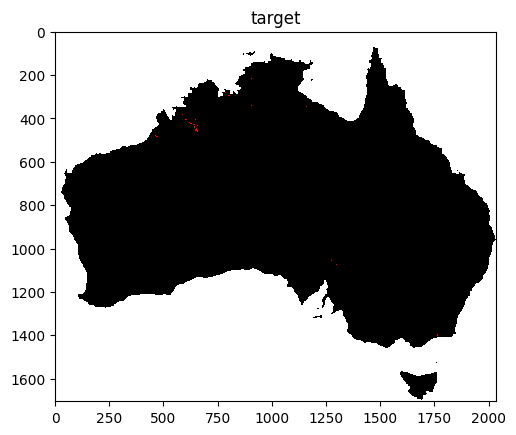

100%|██████████| 13/13 [16:24<00:00, 75.77s/it]


Rasterizing North America


/tmp/ipykernel_25320/2854990052.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  continent_datacube.rename({
  0%|          | 0/13 [00:00<?, ?it/s]

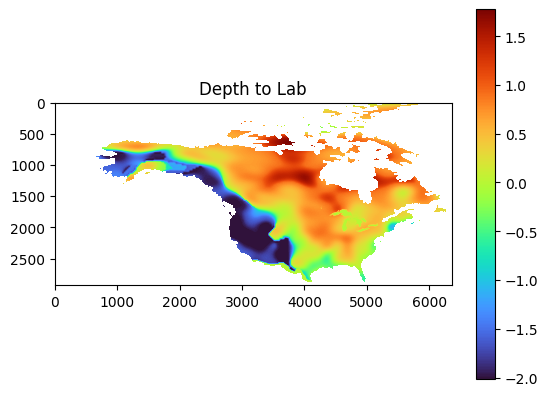

  8%|▊         | 1/13 [03:08<37:40, 188.41s/it]

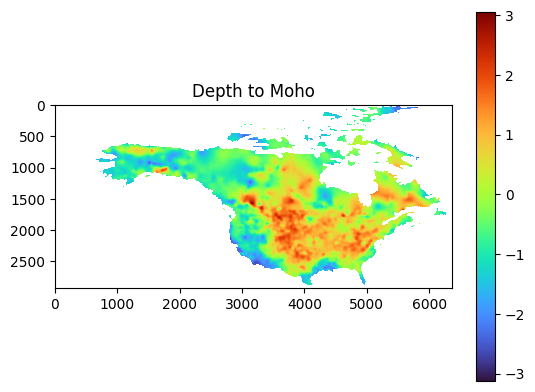

 15%|█▌        | 2/13 [06:16<34:29, 188.13s/it]

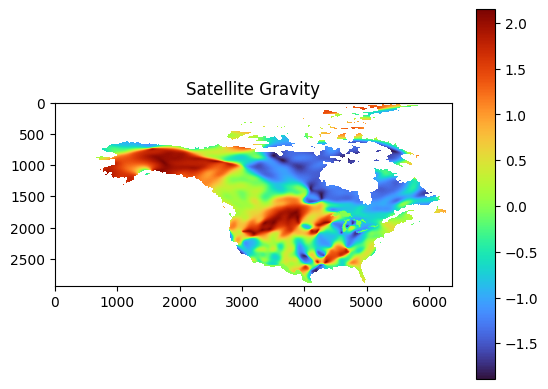

 23%|██▎       | 3/13 [09:37<32:18, 193.87s/it]

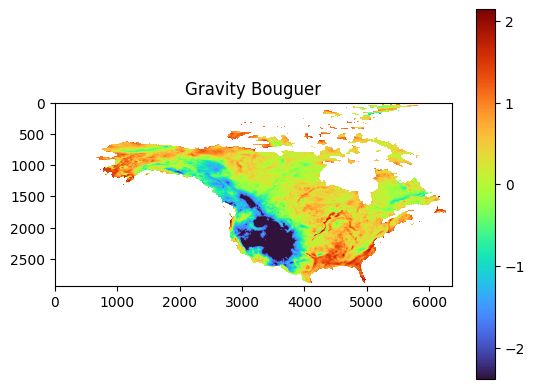

 31%|███       | 4/13 [12:45<28:44, 191.63s/it]

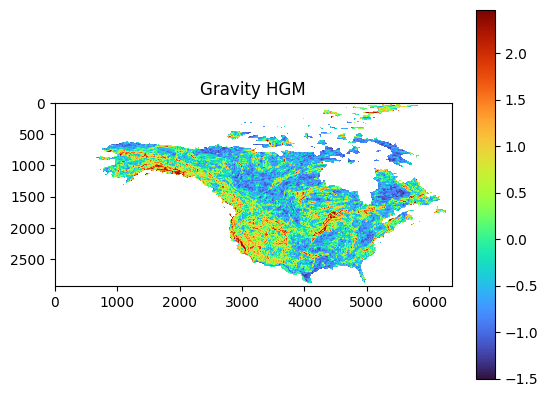

 38%|███▊      | 5/13 [15:53<25:22, 190.26s/it]

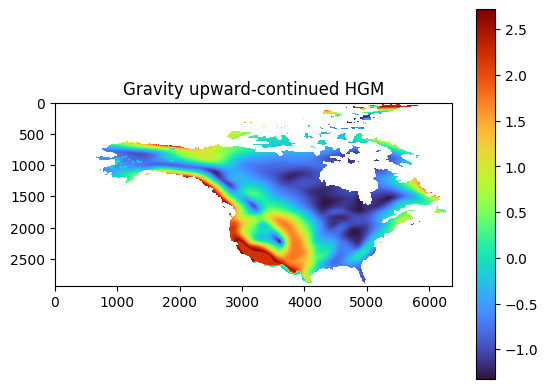

 46%|████▌     | 6/13 [19:02<22:10, 190.06s/it]

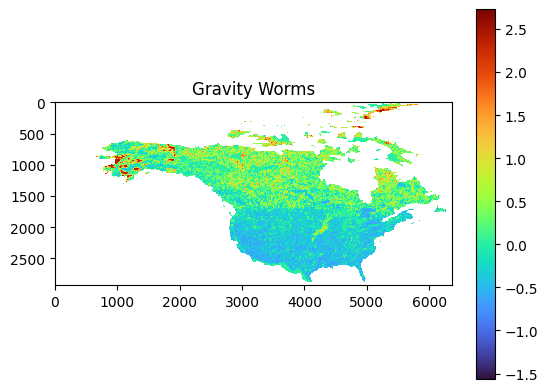

 54%|█████▍    | 7/13 [22:09<18:53, 188.95s/it]

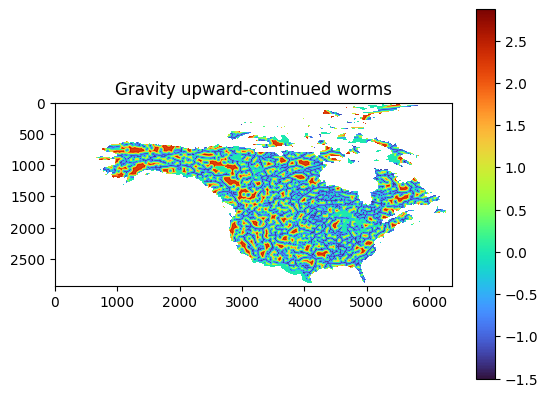

 62%|██████▏   | 8/13 [25:17<15:43, 188.68s/it]

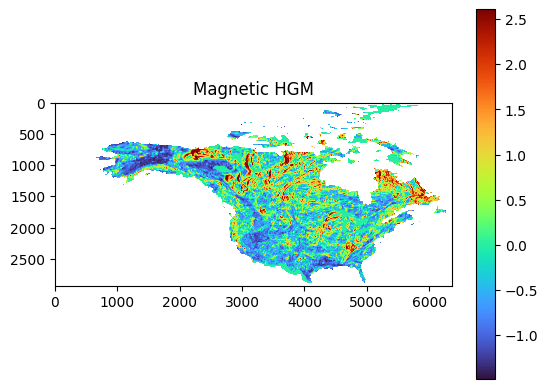

 69%|██████▉   | 9/13 [28:27<12:35, 188.95s/it]

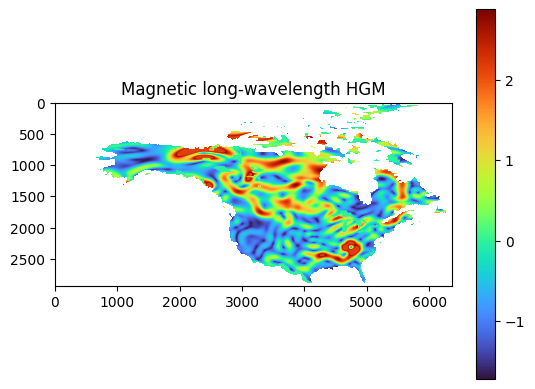

 77%|███████▋  | 10/13 [31:36<09:27, 189.18s/it]

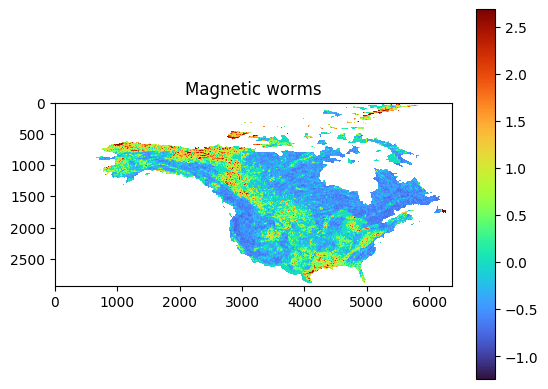

 85%|████████▍ | 11/13 [34:45<06:17, 188.92s/it]

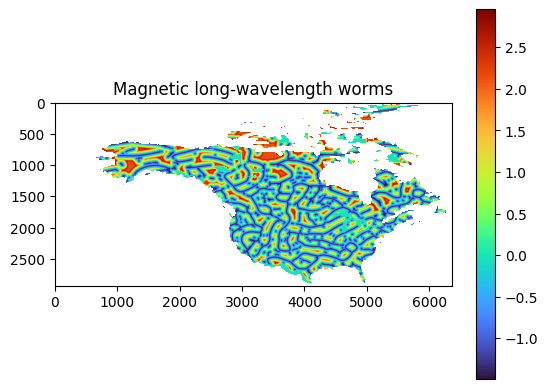

 92%|█████████▏| 12/13 [37:52<03:08, 188.39s/it]

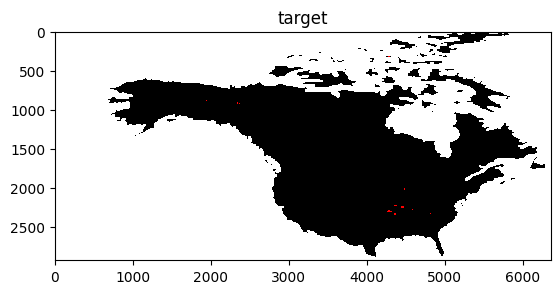

100%|██████████| 13/13 [40:49<00:00, 188.45s/it]


In [16]:
continents = {
    "Oceania": {'left':112.9, 'bottom':-43.6, 'right':153.6, 'top':-9.5},
    "North America": {'left':-179.8, 'bottom':24.5, 'right':-52.6, 'top':83.15}
}

resolution = (0.02, 0.02)

data_filtered["H3_Geometry"] = data_filtered["H3_Geometry"].apply(wkt.loads)

nodata_value = rasterio.open("./data2/GeophysicsGravity_Australia.tif").nodata

for idx, (continent, bounds) in enumerate(continents.items()):
    print(f"Rasterizing {continent}")
    continent_datacube = data_filtered[data_filtered["Continent_Majority"] == continent]

    height = int((bounds["top"]-bounds["bottom"]) / resolution[0])
    width = int((bounds["right"]-bounds["left"]) / resolution[1])

    tif_tf = rasterio.transform.from_bounds(
        bounds["left"],
        bounds["bottom"],
        bounds["right"],
        bounds["top"],
        width,
        height
    )

    tiff_meta = {
        "driver": 'GTiff',
        "height": height,
        "width": width,
        "count": 1,
        "dtype": "float64",
        "crs": rasterio.CRS.from_epsg(4326),
        "transform": tif_tf,
        "nodata": nodata_value,
        "compress": "lzw",
    }

    continent_datacube.rename({
        "GeophysicsLAB": "Depth to Lab",
        "GeophysicsMoho": "Depth to Moho",
        "GeophysicsSatelliteGravity_ShapeIndex": "Satellite Gravity",
        "GeophysicsGravity": "Gravity Bouguer",
        "GeophysicsGravity_HGM": "Gravity HGM",
        "GeophysicsGravity_UpCont30km_HGM": "Gravity upward-continued HGM",
        "ShallowGravitySources_Worms": "Gravity Worms",
        "DeepGravitySources_Worms": "Gravity upward-continued worms",
        "GeophysicsMagRTP_HGM": "Magnetic HGM",
        "GeophysicsMagRTP_HGMDeepSources": "Magnetic long-wavelength HGM",
        "ShallowMagSources_Worms": "Magnetic worms",
        "DeepMagSources_Worms": "Magnetic long-wavelength worms"
    }, axis=1, inplace=True)

    utils.visualize_datacube(continent_datacube, tiff_meta)

    utils.rasterize_datacube(continent_datacube, tiff_meta, './data2/', "sri_"+continent.lower().replace(" ","-"))

Note - major differences from Lawley'22 raster (e.g. "Gravity upward-continued HGM") are due to differences in source datasets; minor differences (e.g. "target") are due to changing from H3 to S2 grid.